# EDA

1. **Create trip_duration and sanity-check it**

   * Compute duration in minutes.
   * Check min, max, a few 0/negative/very large values and decide if any trips should be dropped.

2. **Basic data quality on key columns**

   * For `passenger_count`, `trip_distance`, `fare_amount`, `total_amount`, `PULocationID`, `DOLocationID`:
   * Look for missing values, zeros, negatives, or totally unrealistic numbers.

3. **Merge zone lookup + identify the subset you care about**

   * Use `taxi_zone_lookup` to find LocationIDs for **JFK** and **LaGuardia**.
   * Use it to mark which trips are **pickup in Manhattan** and **dropoff at JFK/LGA**.
   * Count how many trips you have for each airport – make sure the subset is big enough.

4. **Distribution of trip_duration for the airport subset**

   * For Manhattan→JFK and Manhattan→LGA separately:
   * Get mean, median, 25th/75th percentiles, and maybe a simple histogram.
   * This is the core of your regression problem.

5. **Time-of-day / day-of-week effect for airport trips**

   * For the airport subset: average trip_duration by **hour of day** and by **day of week**.
   * This will show rush-hour patterns and support your choice of features later.

6. **Relationship between distance and duration for airport trips**

   * For the airport subset: summarize how duration changes with trip_distance, and compute an average speed (distance/duration).
   * Use this to spot clearly broken records (e.g., crazy speeds) and to understand how noisy the target is.

In [216]:
# 1. Imports
import pandas as pd

In [217]:
trip_df = pd.read_csv(r"C:\Users\rijus\Downloads\M365 AML\taxi_data.csv",low_memory=False)
zone_df = pd.read_csv(r"C:\Users\rijus\Downloads\M365 AML\taxi_zone_lookup.csv")

In [218]:
# 4. Convert pickup & dropoff to datetime
trip_df["tpep_pickup_datetime"]  = pd.to_datetime(trip_df["tpep_pickup_datetime"],  errors="coerce")
trip_df["tpep_dropoff_datetime"] = pd.to_datetime(trip_df["tpep_dropoff_datetime"], errors="coerce")

In [219]:
# 5. Create trip duration in minutes
trip_df["trip_duration_min"] = (
    trip_df["tpep_dropoff_datetime"] - trip_df["tpep_pickup_datetime"]
).dt.total_seconds() / 60

In [220]:
# 6. See summary stats of trip_duration_min
trip_df["trip_duration_min"].describe()

count    3.574091e+06
mean     1.727991e+01
std      2.899807e+01
min     -2.088833e+02
25%      8.083333e+00
50%      1.348333e+01
75%      2.143333e+01
max      1.129583e+04
Name: trip_duration_min, dtype: float64

In [221]:
# 7. Check suspicious durations
n_le0   = (trip_df["trip_duration_min"] <= 0).sum()
n_0_1   = ((trip_df["trip_duration_min"] > 0) & (trip_df["trip_duration_min"] <= 1)).sum()
n_gt180 = (trip_df["trip_duration_min"] > 180).sum()

n_le0, n_0_1, n_gt180

(np.int64(47833), np.int64(47427), np.int64(1282))

In [222]:
# Drop trips with duration ≤ 0, 0–1 minute, or > 180 minutes
trip_df = trip_df[
    trip_df["trip_duration_min"].notna() &
    (trip_df["trip_duration_min"] > 1) &
    (trip_df["trip_duration_min"] <= 180)
].copy()

# Optional: check how many rows are left
trip_df.shape

(3477549, 21)

In [223]:
# See columns, types, and non-missing counts
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3477549 entries, 0 to 3574090
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

In [224]:
num_cols = [
    "trip_duration_min",
    "trip_distance",
    "passenger_count",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_amount"
]

trip_df[num_cols].describe()

,trip_duration_min,trip_distance,passenger_count,fare_amount,tip_amount,tolls_amount,total_amount
count,3.477549e+06,3.477549e+06,2.594301e+06,3.477549e+06,3.477549e+06,3.477549e+06,3.477549e+06
mean,1.735347e+01,7.242232e+00,1.328292e+00,1.795382e+01,2.694539e+00,5.534332e-01,2.625936e+01
std,1.347070e+01,6.745304e+02,7.602237e-01,1.981436e+01,3.945630e+00,2.244427e+00,2.418379e+01
min,1.016667e+00,0.000000e+00,0.000000e+00,-9.956000e+02,-8.500000e+01,-9.000000e+01,-1.017610e+03
25%,8.500000e+00,1.130000e+00,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,1.518000e+01
50%,1.381667e+01,2.050000e+00,1.000000e+00,1.350000e+01,2.000000e+00,0.000000e+00,2.075000e+01
75%,2.173333e+01,4.350000e+00,1.000000e+00,2.260000e+01,3.800000e+00,0.000000e+00,3.015000e+01
max,1.798500e+02,2.740824e+05,9.000000e+00,1.213300e+03,5.000000e+02,1.048300e+02,1.223740e+03


In [225]:
trip_df["passenger_count"].value_counts().sort_index()

passenger_count
0.0      16709
1.0    2014047
2.0     372224
3.0     100242
4.0      74682
5.0      10358
6.0       6031
7.0          2
8.0          3
9.0          3
Name: count, dtype: int64

In [226]:
# Keep only trips with at least 1 passenger
trip_df = trip_df[trip_df["passenger_count"] >= 1].copy()

# Check new size
trip_df.shape

(2577592, 21)

In [227]:
# Find LocationIDs for JFK and LaGuardia (search by zone name)
jfk_rows = zone_df[zone_df["Zone"].str.contains("JFK", case=False, na=False)]
lga_rows = zone_df[zone_df["Zone"].str.contains("LaGuardia", case=False, na=False)]

jfk_rows, lga_rows

(     LocationID Borough         Zone service_zone
 131         132  Queens  JFK Airport     Airports,
      LocationID Borough               Zone service_zone
 137         138  Queens  LaGuardia Airport     Airports)

In [228]:
jfk_ids = jfk_rows["LocationID"].tolist()
lga_ids = lga_rows["LocationID"].tolist()

jfk_ids, lga_ids

([132], [138])

In [229]:
# Prepare pickup zone info
pu_zone = zone_df[["LocationID", "Borough", "Zone"]].rename(
    columns={"LocationID": "PULocationID", "Borough": "PU_Borough", "Zone": "PU_Zone"}
)

# Add pickup borough/zone to trips
trip_df = trip_df.merge(pu_zone, on="PULocationID", how="left")

In [230]:
# Prepare dropoff zone info
do_zone = zone_df[["LocationID", "Borough", "Zone"]].rename(
    columns={"LocationID": "DOLocationID", "Borough": "DO_Borough", "Zone": "DO_Zone"}
)

# Add dropoff borough/zone to trips
trip_df = trip_df.merge(do_zone, on="DOLocationID", how="left")

In [231]:
# Boolean filters
is_manhattan_pickup = trip_df["PU_Borough"] == "Manhattan"
is_jfk_dropoff      = trip_df["DOLocationID"].isin(jfk_ids)
is_lga_dropoff      = trip_df["DOLocationID"].isin(lga_ids)

# Keep only Manhattan → (JFK or LGA) trips
airport_trips = trip_df[is_manhattan_pickup & (is_jfk_dropoff | is_lga_dropoff)].copy()

airport_trips.shape

(43129, 25)

In [232]:
airport_trips

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration_min,PU_Borough,PU_Zone,DO_Borough,DO_Zone
79,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,-1.0,-81.69,-2.5,0.0,-0.75,31.466667,Manhattan,Times Sq/Theatre District,Queens,JFK Airport
80,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,1.0,81.69,2.5,0.0,0.75,31.466667,Manhattan,Times Sq/Theatre District,Queens,JFK Airport
306,2,2025-08-01 00:18:05,2025-08-01 00:47:23,1.0,17.16,2.0,N,164,132,2,...,1.0,81.69,2.5,0.0,0.75,29.300000,Manhattan,Midtown South,Queens,JFK Airport
3215,2,2025-08-01 01:08:09,2025-08-01 01:37:01,1.0,17.63,2.0,N,224,132,1,...,1.0,74.75,2.5,0.0,0.75,28.866667,Manhattan,Stuy Town/Peter Cooper Village,Queens,JFK Airport
3565,2,2025-08-01 02:00:39,2025-08-01 02:32:13,1.0,17.61,2.0,N,48,132,2,...,1.0,81.69,2.5,0.0,0.75,31.566667,Manhattan,Clinton East,Queens,JFK Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570104,2,2025-08-31 21:01:11,2025-08-31 21:54:11,1.0,17.60,2.0,N,230,132,2,...,1.0,77.25,2.5,0.0,0.75,53.000000,Manhattan,Times Sq/Theatre District,Queens,JFK Airport
2570573,2,2025-08-31 21:55:07,2025-08-31 22:38:39,2.0,19.85,2.0,N,87,132,2,...,-1.0,-81.69,-2.5,0.0,-0.75,43.533333,Manhattan,Financial District North,Queens,JFK Airport
2570574,2,2025-08-31 21:55:07,2025-08-31 22:38:39,2.0,19.85,2.0,N,87,132,2,...,1.0,81.69,2.5,0.0,0.75,43.533333,Manhattan,Financial District North,Queens,JFK Airport
2575573,1,2025-08-31 23:56:11,2025-09-01 00:26:27,1.0,15.30,2.0,N,141,132,1,...,1.0,82.22,2.5,0.0,0.75,30.266667,Manhattan,Lenox Hill West,Queens,JFK Airport


In [233]:
# How many Manhattan → airport trips?
airport_trips.shape
# Summary stats of trip duration for all airport trips
airport_trips["trip_duration_min"].describe()

count    43129.000000
mean        40.569883
std         17.423908
min          1.366667
25%         26.816667
50%         36.600000
75%         52.750000
max        179.850000
Name: trip_duration_min, dtype: float64

In [234]:
# Label each trip as JFK or LGA based on DOLocationID
airport_trips["airport"] = "LGA"
airport_trips.loc[airport_trips["DOLocationID"].isin(jfk_ids), "airport"] = "JFK"

airport_trips["airport"].value_counts()

airport
LGA    24116
JFK    19013
Name: count, dtype: int64

In [235]:
# Compare trip durations for JFK vs LGA
airport_trips.groupby("airport")["trip_duration_min"].describe()

,count,mean,std,min,25%,50%,75%,max
airport,,,,,,,,
JFK,19013.0,54.287423,15.131032,2.983333,43.633333,54.166667,64.066667,179.850000
LGA,24116.0,29.755006,9.855350,1.366667,22.800000,28.466667,35.166667,178.783333


In [236]:
# Hour of day (0–23)
airport_trips["pickup_hour"] = airport_trips["tpep_pickup_datetime"].dt.hour

# Day of week (0=Mon, 6=Sun)
airport_trips["pickup_dow"] = airport_trips["tpep_pickup_datetime"].dt.dayofweek

In [237]:
hour_summary = (
    airport_trips
    .groupby(["airport", "pickup_hour"])["trip_duration_min"]
    .agg(["count", "mean"])
    .reset_index()
)

hour_summary

,airport,pickup_hour,count,mean
0,JFK,0,28,39.525595
1,JFK,1,25,37.996000
2,JFK,2,56,35.552083
3,JFK,3,152,31.569846
4,JFK,4,495,31.366835
5,JFK,5,699,34.544254
6,JFK,6,828,38.123792
7,JFK,7,776,41.845511
8,JFK,8,840,47.800575
9,JFK,9,776,51.977942


In [238]:
dow_summary = (
    airport_trips
    .groupby(["airport", "pickup_dow"])["trip_duration_min"]
    .agg(["count", "mean"])
    .reset_index()
)

dow_summary

,airport,pickup_dow,count,mean
0,JFK,0,2355,53.675244
1,JFK,1,2128,53.806187
2,JFK,2,2359,58.228614
3,JFK,3,2774,59.490189
4,JFK,4,3256,58.927529
5,JFK,5,2886,49.245005
6,JFK,6,3255,47.583963
7,LGA,0,2962,29.125129
8,LGA,1,2918,30.199492
9,LGA,2,3594,32.059117


In [239]:
# Summary stats for distance
airport_trips["trip_distance"].describe()

count    43129.000000
mean        13.643242
std          4.260125
min          0.000000
25%          9.980000
50%         12.230000
75%         17.100000
max         47.540000
Name: trip_distance, dtype: float64

In [240]:
airport_trips = airport_trips[airport_trips["trip_distance"] > 0].copy()
airport_trips.shape

(43079, 28)

In [241]:
# Average speed in miles per hour
airport_trips["avg_speed_mph"] = (
    airport_trips["trip_distance"] / (airport_trips["trip_duration_min"] / 60)
)

airport_trips["avg_speed_mph"].describe()

count    43079.000000
mean        22.092794
std          7.071844
min          0.135873
25%         16.952938
50%         20.849421
75%         26.202100
max        301.808219
Name: avg_speed_mph, dtype: float64

In [242]:
# Count trips with very high average speed
n_fast = (airport_trips["avg_speed_mph"] > 80).sum()
n_fast

np.int64(3)

In [243]:
airport_trips = airport_trips[airport_trips["avg_speed_mph"] <= 80].copy()
airport_trips.shape

(43076, 29)

In [244]:
airport_trips.groupby("airport")[["trip_distance", "trip_duration_min", "avg_speed_mph"]].mean()

,trip_distance,trip_duration_min,avg_speed_mph
airport,,,
JFK,17.730761,54.289765,21.189486
LGA,10.450586,29.752955,22.776497


# Regression

## Simple Baseline Model - Take the median time duration based on Airport, Pickup Day, Pickup Hour

In [245]:
from sklearn.model_selection import train_test_split

# Split into train and test
train_df, test_df = train_test_split(
    airport_trips,
    test_size=0.2,
    random_state=42
)

train_df.shape, test_df.shape

((34460, 29), (8616, 29))

In [246]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Columns we use to define the group
group_cols = ["airport", "pickup_hour", "pickup_dow"]

# Median table from TRAIN data
median_table = (
    train_df
    .groupby(group_cols)["trip_duration_min"]
    .median()
    .reset_index()
    .rename(columns={"trip_duration_min": "median_duration"})
)

median_table

,airport,pickup_hour,pickup_dow,median_duration
0,JFK,0,0,40.033333
1,JFK,0,3,27.433333
2,JFK,0,4,43.641667
3,JFK,0,5,44.566667
4,JFK,0,6,29.516667
...,...,...,...,...
320,LGA,23,2,17.750000
321,LGA,23,3,17.166667
322,LGA,23,4,26.433333
323,LGA,23,5,13.850000


In [247]:
# Merge medians into TEST data
test_with_med = test_df.merge(
    median_table,
    on=group_cols,
    how="left"
)

# If a combo in test wasn't seen in train, use overall median duration
overall_median = train_df["trip_duration_min"].median()
test_with_med["median_duration"].fillna(overall_median, inplace=True)

C:\Users\rijus\AppData\Local\Temp\ipykernel_27812\1238658813.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_with_med["median_duration"].fillna(overall_median, inplace=True)


In [248]:
# Baseline predictions
y_test = test_with_med["trip_duration_min"]
y_pred_baseline = test_with_med["median_duration"]

# Evaluate baseline
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)  # no 'squared' arg
rmse_baseline = np.sqrt(mse_baseline)

r2_baseline = r2_score(y_test, y_pred_baseline)

mae_baseline, rmse_baseline, r2_baseline

(6.792884362426493, np.float64(9.499500252324358), 0.7030597259105018)

## Random Forest Regression using trip distance, passenger count, pickup hour, pickup day and airport

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Columns we want to use
feature_cols = ["trip_distance", "passenger_count", "pickup_hour", "pickup_dow", "airport"]

# Drop rows with missing values in these columns or in target
model_df = airport_trips.dropna(subset=feature_cols + ["trip_duration_min"]).copy()

# X = features, y = target
X = model_df[feature_cols]
y = model_df["trip_duration_min"]

# Turn 'airport' (JFK/LGA) into dummy variables
X = pd.get_dummies(X, columns=["airport"], drop_first=True)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [251]:
# Simple Random Forest with very basic settings
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [252]:
y_pred = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)

mse_rf = mean_squared_error(y_test, y_pred)  # no 'squared' arg
rmse_rf = np.sqrt(mse_rf)

r2_rf = r2_score(y_test, y_pred)

mae_rf, rmse_rf, r2_rf

(6.690645663774417, np.float64(9.34494612013056), 0.7126433901885424)

In [253]:
# Get feature importances from the random forest
importances = rf_model.feature_importances_
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_imp

,feature,importance
4,airport_LGA,0.497245
2,pickup_hour,0.207772
0,trip_distance,0.199365
3,pickup_dow,0.072446
1,passenger_count,0.023172


In [254]:
X_train["airport_LGA"].head()   # to see first few values

2106162    False
11199       True
534717     False
2091480    False
713905     False
Name: airport_LGA, dtype: bool

# Classification

## Baseline model - Median duration (% Late vs % Not Late) and Logistic Regression

In [255]:
group_cols = ["airport", "pickup_hour", "pickup_dow"]

median_dur = (
    airport_trips
    .groupby(group_cols)["trip_duration_min"]
    .median()
    .reset_index()
    .rename(columns={"trip_duration_min": "median_duration"})
)

median_dur.head()

,airport,pickup_hour,pickup_dow,median_duration
0,JFK,0,0,40.033333
1,JFK,0,2,49.016667
2,JFK,0,3,31.416667
3,JFK,0,4,41.050000
4,JFK,0,5,44.566667


In [256]:
# Add typical duration to each trip
airport_trips = airport_trips.merge(median_dur, on=group_cols, how="left")

# Threshold = 1.2 × median (20% longer than typical)
airport_trips["late_threshold"] = 1.2 * airport_trips["median_duration"]

# Trip is late if duration > threshold
airport_trips["is_late"] = (
    airport_trips["trip_duration_min"] > airport_trips["late_threshold"]
).astype(int)

# See class balance
airport_trips["is_late"].value_counts(), airport_trips["is_late"].value_counts(normalize=True)

(is_late
 0    35300
 1     7776
 Name: count, dtype: int64,
 is_late
 0    0.819482
 1    0.180518
 Name: proportion, dtype: float64)

In [257]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Create and fit logistic regression (baseline classifier)
log_clf = LogisticRegression(
    max_iter=1000,      # allow enough iterations to converge
    solver="liblinear"  # good for small/medium feature sets and binary targets
)

log_clf.fit(X_train, y_train)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
# 2. Predictions (classes and probabilities)
y_pred_lr  = log_clf.predict(X_test)              # 0/1 prediction
y_proba_lr = log_clf.predict_proba(X_test)[:, 1]  # P(late = 1)

In [ ]:
# 3. Evaluate logistic regression baseline
acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr  = recall_score(y_test, y_pred_lr)
f1_lr   = f1_score(y_test, y_pred_lr)
auc_lr  = roc_auc_score(y_test, y_proba_lr)

acc_lr, prec_lr, rec_lr, f1_lr, auc_lr

## Random Forest Classifier based on trip distance, passenger count, pickup hour, pickup day, airport

### First trial 25% recall

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

feature_cols = ["trip_distance", "passenger_count", "pickup_hour", "pickup_dow", "airport"]

# Drop rows with missing features or labels
clf_df = airport_trips.dropna(subset=feature_cols + ["is_late"]).copy()

X = clf_df[feature_cols]
y = clf_df["is_late"]

# Turn airport (JFK/LGA) into dummy column airport_LGA
X = pd.get_dummies(X, columns=["airport"], drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keep late/on-time ratio similar in train and test
)

In [ ]:
clf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)

In [ ]:
# Class (0/1) predictions
y_pred = clf.predict(X_test)

# Late probabilities
y_proba = clf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred)
prec_rf = precision_score(y_test, y_pred)
rec_rf = recall_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)
auc_rf = roc_auc_score(y_test, y_proba)

acc_rf, prec_rf, rec_rf, f1_rf, auc_rf

### Setting class = "balanced" and trying different thresholds

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Random Forest that pays more attention to the minority class (late = 1)
clf_bal = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"   # <-- key change
)

clf_bal.fit(X_train, y_train)

In [ ]:
# Class predictions (0/1)
y_pred_bal = clf_bal.predict(X_test)

# Probabilities of being late
y_proba_bal = clf_bal.predict_proba(X_test)[:, 1]

# Metrics for late class
acc_bal  = accuracy_score(y_test, y_pred_bal)
prec_bal = precision_score(y_test, y_pred_bal)
rec_bal  = recall_score(y_test, y_pred_bal)
f1_bal   = f1_score(y_test, y_pred_bal)
auc_bal  = roc_auc_score(y_test, y_proba_bal)

acc_bal, prec_bal, rec_bal, f1_bal, auc_bal

In [ ]:
y_proba_bal = clf_bal.predict_proba(X_test)[:, 1]

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2]

for t in thresholds:
    y_pred_t = (y_proba_bal >= t).astype(int)
    prec_t = precision_score(y_test, y_pred_t)
    rec_t  = recall_score(y_test, y_pred_t)
    f1_t   = f1_score(y_test, y_pred_t)
    print(f"threshold={t:.2f}  precision={prec_t:.3f}  recall={rec_t:.3f}  f1={f1_t:.3f}")

### CatBoost

In [ ]:
# Install if you don't have it
# (run this cell once; you can skip if already installed)
!pip install catboost

In [258]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import pandas as pd
import numpy as np

In [259]:
# Make sure these time columns exist
airport_trips["pickup_hour"] = airport_trips["tpep_pickup_datetime"].dt.hour
airport_trips["pickup_dow"]  = airport_trips["tpep_pickup_datetime"].dt.dayofweek

feature_cols = ["trip_distance", "passenger_count", "pickup_hour", "pickup_dow", "airport", "payment_type"]

# Drop rows with missing features or label
clf_df = airport_trips.dropna(subset=feature_cols + ["is_late"]).copy()

X = clf_df[feature_cols]
y = clf_df["is_late"]

# Turn airport (JFK/LGA) into dummy numeric column
X = pd.get_dummies(X, columns=["airport"], drop_first=True)

X.head(), y.value_counts()

(   trip_distance  passenger_count  pickup_hour  pickup_dow  payment_type  \
 0          17.09              3.0            0           4             4   
 1          17.09              3.0            0           4             4   
 2          17.16              1.0            0           4             2   
 3          17.63              1.0            1           4             1   
 4          17.61              1.0            2           4             2   
 
    airport_LGA  
 0        False  
 1        False  
 2        False  
 3        False  
 4        False  ,
 is_late
 0    35300
 1     7776
 Name: count, dtype: int64)

In [260]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y      # keep class balance similar in train/test
)

In [261]:
# Weight for positive class (late = 1)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
pos_weight

np.float64(4.539302362964154)

In [262]:
cb = CatBoostClassifier(
    iterations=400,          # number of boosting steps
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    scale_pos_weight=pos_weight,   # <-- handle imbalance
    random_state=42,
    verbose=50               # print every 50 iterations
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	test: 0.6728037	best: 0.6728037 (0)	total: 101ms	remaining: 40.5s
50:	test: 0.7205402	best: 0.7206367 (40)	total: 2.18s	remaining: 14.9s
100:	test: 0.7238526	best: 0.7238526 (100)	total: 4.6s	remaining: 13.6s
150:	test: 0.7247037	best: 0.7253887 (124)	total: 7.3s	remaining: 12s
200:	test: 0.7234397	best: 0.7253887 (124)	total: 9.72s	remaining: 9.62s
250:	test: 0.7228278	best: 0.7253887 (124)	total: 12.2s	remaining: 7.24s
300:	test: 0.7217129	best: 0.7253887 (124)	total: 14.6s	remaining: 4.8s
350:	test: 0.7209254	best: 0.7253887 (124)	total: 17.3s	remaining: 2.42s
399:	test: 0.7208322	best: 0.7253887 (124)	total: 19.4s	remaining: 0us

bestTest = 0.7253887233
bestIteration = 124

Shrink model to first 125 iterations.


In [263]:
# Probabilities of being late
y_proba_cb = cb.predict_proba(X_test)[:, 1]

thresholds = [0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]

for t in thresholds:
    y_pred_t = (y_proba_cb >= t).astype(int)
    prec_t = precision_score(y_test, y_pred_t)
    rec_t  = recall_score(y_test, y_pred_t)
    f1_t   = f1_score(y_test, y_pred_t)
    print(f"threshold={t:.2f}  precision={prec_t:.3f}  recall={rec_t:.3f}  f1={f1_t:.3f}")

threshold=0.50  precision=0.299  recall=0.662  f1=0.412
threshold=0.40  precision=0.257  recall=0.826  f1=0.392
threshold=0.35  precision=0.242  recall=0.868  f1=0.378
threshold=0.30  precision=0.226  recall=0.915  f1=0.362
threshold=0.25  precision=0.207  recall=0.954  f1=0.341
threshold=0.20  precision=0.189  recall=0.983  f1=0.318
threshold=0.15  precision=0.183  recall=0.995  f1=0.309
threshold=0.10  precision=0.181  recall=0.999  f1=0.306


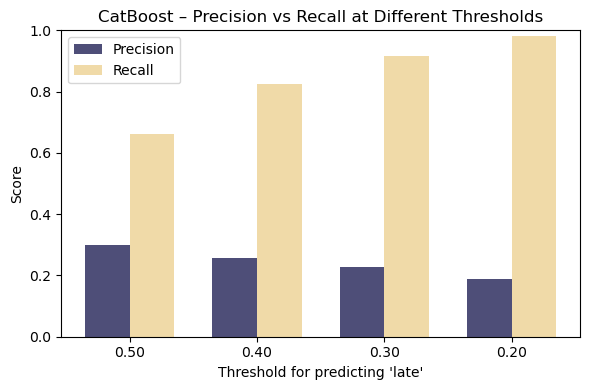

In [274]:
import numpy as np
import matplotlib.pyplot as plt

# From your printout
thresholds = np.array([0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1])
precisions = np.array([0.299, 0.257, 0.242, 0.226, 0.207, 0.189, 0.183, 0.181])
recalls    = np.array([0.662, 0.826, 0.868, 0.915, 0.954, 0.983, 0.995, 0.999])

# Keep thresholds 0.50, 0.40, 0.30, 0.20  (indices 0,1,3,5)
keep = [0, 1, 3, 5]

thr_show = thresholds[keep]
prec_show = precisions[keep]
rec_show  = recalls[keep]

x = np.arange(len(thr_show))  # 0..3
width = 0.35

plt.figure(figsize=(6,4))

plt.bar(x - width/2, prec_show, width, label="Precision", color="#4E4E78")
plt.bar(x + width/2, rec_show,  width, label="Recall",    color="#F0DAA8")

plt.xticks(x, [f"{t:.2f}" for t in thr_show])
plt.ylim(0, 1)
plt.xlabel("Threshold for predicting 'late'")
plt.ylabel("Score")
plt.title("CatBoost – Precision vs Recall at Different Thresholds")
plt.legend()
plt.tight_layout()
plt.savefig("threshold_comparison.png", dpi=300)  # <- save
plt.show()

# Visualizations related to Classification

### Grouped bar chart – Logistic vs RF (Accuracy / Precision / Recall / F1)

In [185]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Use threshold 0.4 for CatBoost
cb_threshold = 0.4

y_pred_cb = (y_proba_cb >= cb_threshold).astype(int)

accuracy_cb  = accuracy_score(y_test, y_pred_cb)
precision_cb = precision_score(y_test, y_pred_cb)
recall_cb    = recall_score(y_test, y_pred_cb)
f1_cb        = f1_score(y_test, y_pred_cb)

# AUC uses probabilities, so it doesn't depend on the threshold
auc_cb = roc_auc_score(y_test, y_proba_cb)

accuracy_cb, precision_cb, recall_cb, f1_cb, auc_cb

(0.5374883936861653,
 0.257,
 0.8263665594855305,
 0.39206712433257057,
 np.float64(0.7253887232572744))

In [209]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logistic regression metrics
acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr  = recall_score(y_test, y_pred_lr)
f1_lr   = f1_score(y_test, y_pred_lr)

# Random Forest metrics
acc_rf  = accuracy_score(y_test, y_pred)
prec_rf = precision_score(y_test, y_pred)
rec_rf  = recall_score(y_test, y_pred)
f1_rf   = f1_score(y_test, y_pred)

import numpy as np

all_metrics = {
    "acc_lr": acc_lr, "prec_lr": prec_lr, "rec_lr": rec_lr, "f1_lr": f1_lr,
    "acc_rf": acc_rf, "prec_rf": prec_rf, "rec_rf": rec_rf, "f1_rf": f1_rf,
    "accuracy_cb": accuracy_cb, "precision_cb": precision_cb,
    "recall_cb": recall_cb, "f1_cb": f1_cb,
}

for name, val in all_metrics.items():
    print(name, "->", type(val), np.shape(val))


acc_lr -> <class 'float'> ()
prec_lr -> <class 'float'> ()
rec_lr -> <class 'float'> ()
f1_lr -> <class 'float'> ()
acc_rf -> <class 'float'> ()
prec_rf -> <class 'float'> ()
rec_rf -> <class 'float'> ()
f1_rf -> <class 'float'> ()
accuracy_cb -> <class 'float'> ()
precision_cb -> <class 'float'> ()
recall_cb -> <class 'float'> ()
f1_cb -> <class 'float'> ()


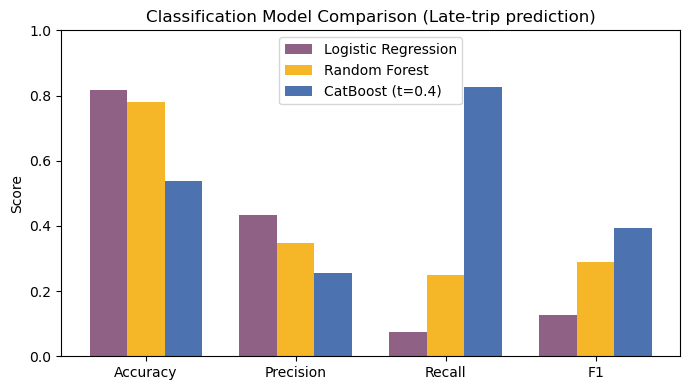

In [212]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1"]

lr_scores = [acc_lr,  prec_lr,  rec_lr,  f1_lr]
rf_scores = [acc_rf,  prec_rf,  rec_rf,  f1_rf]
cb_scores = [accuracy_cb, precision_cb, recall_cb, f1_cb]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(7, 4))

plt.bar(x - width, lr_scores, width, label="Logistic Regression", color="#8F6185")
plt.bar(x,         rf_scores, width, label="Random Forest",       color="#F5B727")
plt.bar(x + width, cb_scores, width, label="CatBoost (t=0.4)",    color="#4C72B0")

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Classification Model Comparison (Late-trip prediction)")
plt.legend()
plt.tight_layout()
plt.savefig("classification_comparison.png", dpi=300)  # <- save
plt.show()

### ROC curves – Logistic vs RF

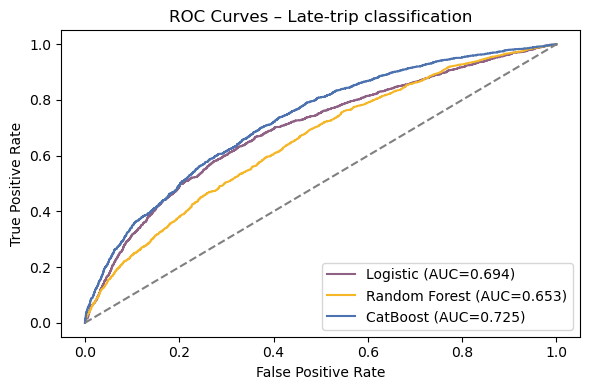

In [206]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC points
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba)   # use your RF prob var here
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_proba_cb)

# AUCs
auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_rf = roc_auc_score(y_test, y_proba)
auc_cb = roc_auc_score(y_test, y_proba_cb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})",   color="#8F6185")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})", color="#F5B727")
plt.plot(fpr_cb, tpr_cb, label=f"CatBoost (AUC={auc_cb:.3f})",  color="#4C72B0")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Late-trip classification")
plt.legend()
plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=300)  # <- save
plt.show()

### Precision–Recall curves – Logistic vs RF

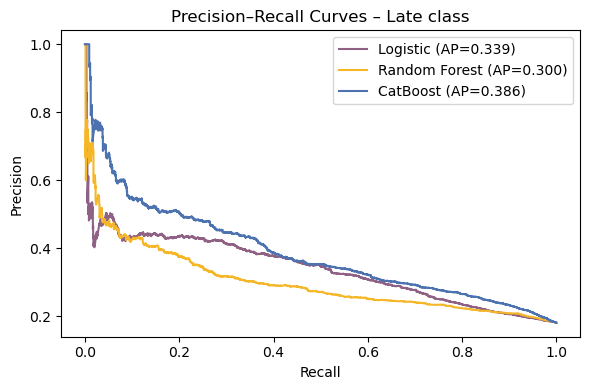

In [214]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# PR points
prec_lr, rec_lr_curve, _ = precision_recall_curve(y_test, y_proba_lr)
prec_rf, rec_rf_curve, _ = precision_recall_curve(y_test, y_proba)
prec_cb, rec_cb_curve, _ = precision_recall_curve(y_test, y_proba_cb)

# Average precision (area under PR curve)
ap_lr = average_precision_score(y_test, y_proba_lr)
ap_rf = average_precision_score(y_test, y_proba)
ap_cb = average_precision_score(y_test, y_proba_cb)

plt.figure(figsize=(6, 4))
plt.plot(rec_lr_curve, prec_lr, label=f"Logistic (AP={ap_lr:.3f})",   color="#8F6185")
plt.plot(rec_rf_curve, prec_rf, label=f"Random Forest (AP={ap_rf:.3f})", color="#F5B727")
plt.plot(rec_cb_curve, prec_cb, label=f"CatBoost (AP={ap_cb:.3f})",  color="#4C72B0")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Late class")
plt.legend()
plt.tight_layout()
plt.savefig("pr_comparison.png", dpi=300)  # <- save
plt.show()